In [189]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from math import inf

In [190]:
def draw_graph(G):
    pos = nx.shell_layout(G) 

    Rs = [G[u][v]['R'] for u,v in G.edges()]
    max_R = max(Rs)

    weights = [i*8/max_R for i in Rs]

    colors = ['r','g','b','pink','purple','black','yellow','grey','orange']
    cc=[]
    for i in range(len(Rs)):

        n = len(colors)
        x = random.randint(0,n-1)
        cc.append(colors[x])

    edge_labels = dict([((n1, n2), round(Rs[i],2))
                    for i, (n1, n2) in enumerate(G.edges)])

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)

    nx.draw(G,pos, width=weights,edge_color=cc,node_color='lightgreen')

In [471]:


def analysis(G, s, t, E):
    

    G.add_edge(s,t, R=0)


    if not nx.is_weakly_connected(G.to_directed()):
        raise Exception("graph is not connected")

    if not (s in G.nodes() and t in G.nodes()):
        raise Exception('Voltage applied to invalid nodes')


    n = G.number_of_edges()
    A = np.zeros((n,n))
    B = np.zeros(n)

    cycles = nx.cycle_basis(G)
    #edges contains only one edge between node u and v, even though G.edges(u) and G.edges(v) exist as the opposite
    edges = list(G.edges())
    
    #1st Kirchoffs law
    node = 0
    numOfEq = 0

    while node < G.number_of_nodes()-1:
        
        if type(G.edges(node))!= type(int):
            for edge in G.edges(node):
                sign = 1
                (u, v) = edge
                if edge not in edges:
                    sign = -1
                    (u,v) = edge[1], edge[0]
                j = edges.index((u,v))
                A[numOfEq, j] = sign

            numOfEq += 1
        node += 1

    #2nd Kirchoffs law
    for cycle in cycles:
        
        for j in range(len(cycle)):
            if j < len(cycle)-1:
                 edge = (cycle[j], cycle[j+1])
            else:
                 edge = (cycle[j], cycle[0])

            if edge == (s, t):
                B[numOfEq] = E
            elif edge == (t, s):
                B[numOfEq] = -E
            
            else:
                (u, v) = edge
                if edge in edges:
                    j = edges.index((u,v))
                    A[numOfEq,j] = G.get_edge_data(u,v)['R']
                else: 
                    j = edges.index((v,u))
                    A[numOfEq,j] = -G.get_edge_data(v,u)['R']
        numOfEq += 1
        if numOfEq>=n:
            break
  
    res = np.linalg.solve(A,B)


    def buildSolution():   

        solution = nx.DiGraph()
        for i, (u,v) in enumerate(edges):

            intensity = res[i]
            abc = abs(res[i])
            if intensity>0:
                solution.add_edge(u,v,R=abc)
            else:
                solution.add_edge(v,u,R=abc)

        return solution

    solution = buildSolution()

    def checkSolution(G):   
        draw_graph(G)
        edges = list(G.edges())
        for node in G.nodes():
            I = 0
            for (u,v) in G.in_edges(node):
                I += G.get_edge_data(u,v)['R']
            for (u,v) in G.out_edges(node):
                I -= G.get_edge_data(u,v)['R']
            if I > 1e-6:
                raise Exception("Solution does not meet Kirchoffs 1st law")

    checkSolution(solution)


    return solution







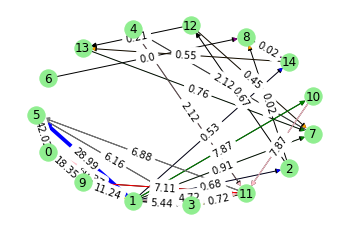

In [474]:
n = 15

def gen_graph():
    G = nx.Graph()
    for u in range(n):
        for v in range(u+1, n):
            if random.random() < 0.18:
                R = random.randint(1, 5)

                G.add_edge(u, v, R=R)

    return G
    
s, t = 0, 1
E = 100
G = gen_graph()

while True:
    res = analysis(G, s, t, E)
    if res != 1:
        break
    G = gen_graph()